In [11]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 4060

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
from torchvision import transforms

# Transformaciones para entrenamiento (aumentos + normalización)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0,
                            translate=(0.05, 0.05)),  # equivalente a width/height_shift
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Transformaciones para validación y test (solo reescalado + normalización)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

Clases: ['Benign', 'Malignant']


In [13]:
import os, math, numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# rutas (según tu estructura)
# lo que tenías (mal): BASE_DIR = os.path.join("002cancer")
BASE_DIR = os.path.join("..", "002_cancer")  # desde /notebooks sube a ../002_cancer
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

# parámetros que me pediste
CLASSES = 2
BATCH   = 32
ROWS = COLS = 224
INPUT_CH = 3
EPOCHS  = 25
TEST_MAX_SAMPLES = 2000
SEED    = 42

# dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:",DEVICE)
torch.manual_seed(SEED)
np.random.seed(SEED)

Usando dispositivo: cuda


In [32]:
# ===== Datasets & Dataloaders =====
from torch.utils.data import random_split

# Comprobación de carpetas
for p in [TRAIN_DIR, TEST_DIR]:
    assert os.path.isdir(os.path.join(p, "Benign")),    f"Falta {p}/Benign"
    assert os.path.isdir(os.path.join(p, "Malignant")), f"Falta {p}/Malignant"

use_explicit_val = os.path.isdir(VAL_DIR) and all(
    os.path.isdir(os.path.join(VAL_DIR, c)) for c in ["Benign", "Malignant"]
)

if use_explicit_val:
    train_ds = datasets.ImageFolder(TRAIN_DIR, transform=transform_train)
    val_ds   = datasets.ImageFolder(VAL_DIR,   transform=transform_eval)
else:
    # Split desde TRAIN -> (train, val)
    full_train = datasets.ImageFolder(TRAIN_DIR, transform=transform_train)
    val_ratio  = 0.2
    n_total    = len(full_train)
    n_val      = int(n_total * val_ratio)
    n_train    = n_total - n_val
    train_ds, val_ds = random_split(
        full_train, [n_train, n_val],
        generator=torch.Generator().manual_seed(SEED)
    )

test_ds  = datasets.ImageFolder(TEST_DIR, transform=transform_eval)

NUM_WORKERS = 0 if os.name == "nt" else 4
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))

# Mapeo de clases
if use_explicit_val:
    class_to_idx = datasets.ImageFolder(TRAIN_DIR).class_to_idx
else:
    class_to_idx = train_ds.dataset.class_to_idx if hasattr(train_ds, "dataset") else datasets.ImageFolder(TRAIN_DIR).class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print("Clases:", class_to_idx)
print(f"Train={len(train_ds)} | Val={len(val_ds)} | Test={len(test_ds)}")

Clases: {'Benign': 0, 'Malignant': 1}
Train=9504 | Val=2375 | Test=2000


In [33]:
# ===== Modelo básico (CNN pequeña) — FIXED =====
import torch.nn as nn
import math

class BasicCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                          # 224 -> 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                          # 112 -> 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                          # 56 -> 28

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                          # 28 -> 14
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))      # -> (B,256,1,1)
        self.classifier = nn.Sequential(
            nn.Flatten(),                             # -> (B,256)
            nn.Dropout(0.30),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.30),
            nn.Linear(128, num_classes)               # logits
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

# Instancia con tus parámetros globales
model = BasicCNN(in_ch=INPUT_CH, num_classes=CLASSES).to(DEVICE)
print(model)

BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13

In [34]:
# Criterio y optimizador (regu suave) + utilidades
import torch
from torch import nn, optim

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=3e-4)
USE_AMP   = (DEVICE.type == "cuda")
scaler    = torch.cuda.amp.GradScaler(enabled=USE_AMP)
GRAD_CLIP = 1.0  # recorta gradientes grandes
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Hook por si luego quieres 4 canales/heatmap; aquí no hace nada
def preprocess_batch(x):
    return x

C:\Users\1cnac\AppData\Local\Temp\ipykernel_26296\3820174030.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [35]:
# Entrenamiento completo (sin early stopping) guardando histórico
import numpy as np, os

history = {
    "train_loss":[], "val_loss":[],
    "train_acc": [], "val_acc": [],
    "train_prec":[], "val_prec":[]
}
best_val_acc = 0.0
os.makedirs("models", exist_ok=True)
ckpt_path = os.path.join("models", "basiccnn_best.pt")

def epoch_pass(loader, train=True):
    model.train() if train else model.eval()
    total, correct, running_loss = 0, 0, 0.0
    tp, pred_pos = 0, 0
    for x, y in loader:
        x = preprocess_batch(x)
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(x)
            loss   = criterion(logits, y)

        if train:
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                if GRAD_CLIP:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward()
                if GRAD_CLIP:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                optimizer.step()

        probs = torch.softmax(logits.detach(), dim=1)
        preds = probs.argmax(dim=1)

        correct     += (preds == y).sum().item()
        total       += y.size(0)
        running_loss+= loss.item() * y.size(0)
        pred_pos    += (preds == 1).sum().item()
        tp          += ((preds == 1) & (y == 1)).sum().item()

    avg_loss = running_loss / total
    acc      = correct / total
    prec     = (tp / pred_pos) if pred_pos > 0 else 0.0
    return avg_loss, acc, prec

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_prec = epoch_pass(train_loader, train=True)
    va_loss, va_acc, va_prec = epoch_pass(test_loader,  train=False)  # usamos test como "val"

    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    history["train_prec"].append(tr_prec); history["val_prec"].append(va_prec)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), ckpt_path)

    scheduler.step()

    print(f"Epoch {epoch:02d} | "
          f"Train: loss={tr_loss:.4f} acc={tr_acc:.4f} prec={tr_prec:.4f} | "
          f"Val:   loss={va_loss:.4f} acc={va_acc:.4f} prec={va_prec:.4f}")

print(f"Mejor val_acc: {best_val_acc:.4f}  (checkpoint: {ckpt_path})")

# carga el mejor para evaluar/inferir
state = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(state); model.eval()

C:\Users\1cnac\AppData\Local\Temp\ipykernel_26296\1852085342.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=USE_AMP):


Epoch 01 | Train: loss=0.4735 acc=0.7945 prec=0.7782 | Val:   loss=0.4641 acc=0.7865 prec=0.8343
Epoch 02 | Train: loss=0.4263 acc=0.8224 prec=0.8063 | Val:   loss=0.4347 acc=0.8185 prec=0.9099
Epoch 03 | Train: loss=0.4080 acc=0.8371 prec=0.8172 | Val:   loss=0.3961 acc=0.8380 prec=0.8634
Epoch 04 | Train: loss=0.4021 acc=0.8396 prec=0.8265 | Val:   loss=0.4049 acc=0.8405 prec=0.8865
Epoch 05 | Train: loss=0.3903 acc=0.8536 prec=0.8377 | Val:   loss=0.4927 acc=0.8020 prec=0.9126
Epoch 06 | Train: loss=0.3856 acc=0.8522 prec=0.8381 | Val:   loss=0.4446 acc=0.8075 prec=0.8801
Epoch 07 | Train: loss=0.3853 acc=0.8544 prec=0.8387 | Val:   loss=0.4019 acc=0.8375 prec=0.8875
Epoch 08 | Train: loss=0.3783 acc=0.8565 prec=0.8423 | Val:   loss=0.4112 acc=0.8350 prec=0.9351
Epoch 09 | Train: loss=0.3697 acc=0.8624 prec=0.8473 | Val:   loss=0.3714 acc=0.8610 prec=0.8849
Epoch 10 | Train: loss=0.3725 acc=0.8623 prec=0.8485 | Val:   loss=0.3726 acc=0.8645 prec=0.9194
Epoch 11 | Train: loss=0.3698 

C:\Users\1cnac\AppData\Local\Temp\ipykernel_26296\1852085342.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=DEVICE)


BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13

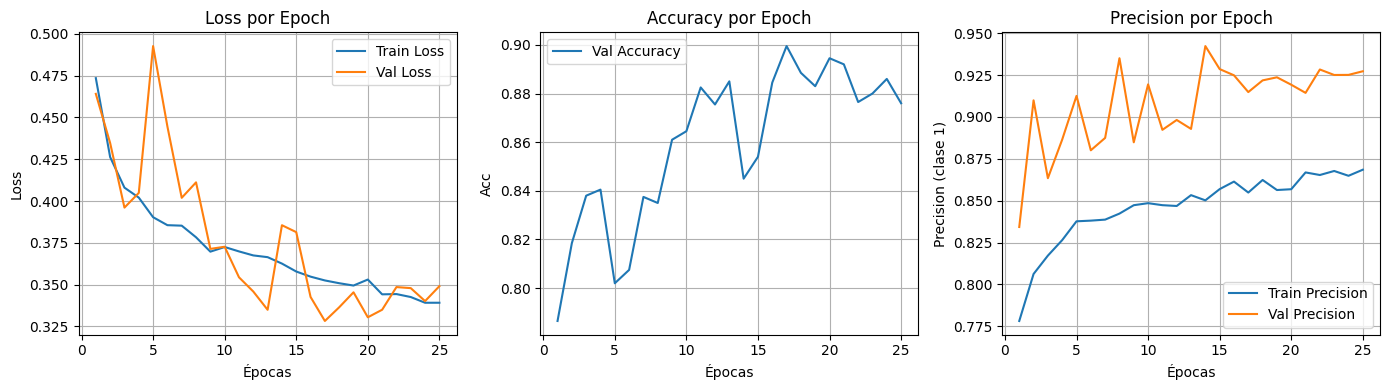

In [36]:
import numpy as np, matplotlib.pyplot as plt

epochs = np.arange(1, len(history["train_loss"])+1)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"],   label="Val Loss")
plt.title("Loss por Epoch"); plt.xlabel("Épocas"); plt.ylabel("Loss")
plt.grid(True); plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, history["val_acc"], label="Val Accuracy")
plt.title("Accuracy por Epoch"); plt.xlabel("Épocas"); plt.ylabel("Acc")
plt.grid(True); plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, history["train_prec"], label="Train Precision")
plt.plot(epochs, history["val_prec"],   label="Val Precision")
plt.title("Precision por Epoch"); plt.xlabel("Épocas"); plt.ylabel("Precision (clase 1)")
plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()

Umbral elegido: 0.375 | prec=0.883 rec=0.934 f1=0.908
AUC: 0.9602099999999999


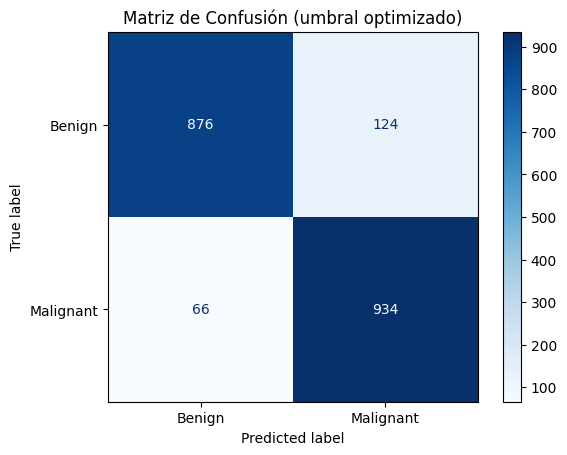

TN=876  FP=124  FN=66  TP=934


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np, matplotlib.pyplot as plt

# Probabilidades en el "val" (estás usando test_loader como val)
y_true, prob1 = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE, non_blocking=True)
        p1 = torch.softmax(model(x), dim=1)[:,1].cpu().numpy()
        y_true.append(y.numpy()); prob1.append(p1)
y_true = np.concatenate(y_true); prob1 = np.concatenate(prob1)

# Barrido de umbral
thresholds = np.linspace(0.10, 0.90, 33)
rows=[]
for th in thresholds:
    pred = (prob1 >= th).astype(int)
    rows.append( (th,
                  precision_score(y_true, pred, zero_division=0),
                  recall_score(y_true, pred, zero_division=0),
                  f1_score(y_true, pred, zero_division=0)) )
best_f1 = max(rows, key=lambda r: r[3])

RECALL_OBJ = None   # e.g., 0.90 si quieres priorizar sensibilidad; None => usa mejor F1
if RECALL_OBJ is not None:
    cand = [r for r in rows if r[2] >= RECALL_OBJ]
    chosen = cand[0] if cand else best_f1
else:
    chosen = best_f1

th = chosen[0]
print(f"Umbral elegido: {th:.3f} | prec={chosen[1]:.3f} rec={chosen[2]:.3f} f1={chosen[3]:.3f}")
print("AUC:", roc_auc_score(y_true, prob1))

pred = (prob1 >= th).astype(int)
cm = confusion_matrix(y_true, pred)     # [[TN,FP],[FN,TP]]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión (umbral optimizado)")
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")